Aim to make **a Recommendation System** by implementing **user-based CF**, using Spotlight toolkit

In [1]:
import numpy as np
import pandas as pd
import torch
seed=20

We will use movielens dataset 

In [2]:
!curl -o ml-latest-small.zip http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# backup location
#!curl -o ml-latest-small.zip http://www.dcs.gla.ac.uk/~craigm/recsysHM/ml-latest-small.zip
!unzip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   888k      0  0:00:01  0:00:01 --:--:--  888k
Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


The ratings given by user are in ratings.csv. And the movie details are in movies.csv. Now we are going to load them to pandas Dataframe.

In [3]:
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
movies_df = pd.read_csv("ml-latest-small/movies.csv")

# we're going to treat userId as strings, and similarly as movies. This will prevent confusion later on.
ratings_df['userId'] =  "u" + ratings_df['userId'].astype(str)
ratings_df['movieId'] = "m" + ratings_df['movieId'].astype(str)
movies_df['movieId'] = "m" +  movies_df['movieId'].astype(str)

In [4]:
ratings_df.head(5)

,userId,movieId,rating,timestamp
0,u1,m1,4.0,964982703
1,u1,m3,4.0,964981247
2,u1,m6,4.0,964982224
3,u1,m47,5.0,964983815
4,u1,m50,5.0,964982931


In [5]:
movies_df.head(10)

,movieId,title,genres
0,m1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,m2,Jumanji (1995),Adventure|Children|Fantasy
2,m3,Grumpier Old Men (1995),Comedy|Romance
3,m4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,m5,Father of the Bride Part II (1995),Comedy
5,m6,Heat (1995),Action|Crime|Thriller
6,m7,Sabrina (1995),Comedy|Romance
7,m8,Tom and Huck (1995),Adventure|Children
8,m9,Sudden Death (1995),Action
9,m10,GoldenEye (1995),Action|Adventure|Thriller


**User-based CF**

Let's generate a matrix of ratings with the ratings_df dataframe. In the matrix, the unrated items are filled with 0 (this means they have no impact upon the calculated Cosine value).

In [6]:
r_df_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
r_df_matrix

movieId,m1,m10,m100,m100044,m100068,m100083,m100106,m100159,m100163,m100194,...,m99750,m99764,m998,m99813,m99846,m99853,m999,m99910,m99917,m99992
userId,,,,,,,,,,,,,,,,,,,,,
u1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u96,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index allows fast lookup of rows. Here, userID is our index column.

In [7]:
r_df_matrix.loc['u99']

movieId
m1         0.0
m10        4.0
m100       0.0
m100044    0.0
m100068    0.0
          ... 
m99853     0.0
m999       0.0
m99910     0.0
m99917     0.0
m99992     0.0
Name: u99, Length: 9724, dtype: float64

In [8]:
r_df_matrix.loc['u99'].values

array([0., 4., 0., ..., 0., 0., 0.])

We will use **Cosine Similarity** for user-based CF. It can be implemented through numpy library.

In [9]:
from numpy.linalg import norm
from numpy import dot

# define cosine function
def cos_sim(a, b):
  return dot(a, b)/(norm(a)*norm(b))
  
print('Cosine similarity between userId=1 and userId=607 is:')
print(cos_sim(r_df_matrix.loc['u1'].values, r_df_matrix.loc['u607'].values))

Cosine similarity between userId=1 and userId=607 is:
0.2693892401115333


Now we will get **most similar users**. We will use **rankdata()** function to tell positions in sorted rank order.

In [13]:
from scipy.stats import rankdata
import operator

def get_most_similar_users(userId : str, k : int = 10):

  similarity_dict = {} # creating an empty dictionary
  
  for i in r_df_matrix.index:
    similarity_dict[i] = cos_sim(r_df_matrix.loc[userId].values, r_df_matrix.loc[i].values) # appending values in dictionary

  sorted_dict = sorted(similarity_dict.items(), key=operator.itemgetter(1),reverse=True) # sorting dictionary items

  topk_userids = []
  topk_cosines = []

  for i in range (k):
      topk_userids.append(sorted_dict[i+1] [0]) # appending top k users
      topk_cosines.append(sorted_dict[i+1] [1]) # appending top k cosine similarity values
  
  return (topk_userids, topk_cosines)

print(get_most_similar_users(userId='u3', k=1))

(['u313'], [0.07818732282993371])


Let's predict the rating of a given userId for a given itemId.

In [14]:
def predict_rating(userId : str, movieId : str) -> float:

  # finding top 10 most similar users and similarity
  users, similarity_value = get_most_similar_users(userId, k=10)

  similarity_sum, product = 0, 0  # defining variables with zero value

  for i in range(len(users)):
    if r_df_matrix.loc[users[i],movieId]!=0:  # keeping non-zero values

      # implementing weighted sum formula for predicting rating
      product = product + (similarity_value[i] * r_df_matrix.loc[users[i], movieId])
      similarity_sum = similarity_sum + similarity_value[i]
  
  predicted = product/ similarity_sum

  return predicted

print("Predicted rating:", predict_rating(userId='u1', movieId='m1'))

print("Actual rating:", r_df_matrix.loc['u1']['m1'])

Predicted rating: 3.898822026597358
Actual rating: 4.0


**Mean-center normalisation**

Users usually rate differently: (1) some rate high, while others low. (2) Some use more of the scale than others. However, the user-based CF we implemented above ignores these differences. To this end, we can apply normalisation to compensate. 

In [15]:
def mean_rating(userId : str) -> float:

  user_ratings = r_df_matrix.loc[userId]  # getting user ratings from dataframe 

  non_zero_ratings = []
  for i in user_ratings:
    if i!=0:  # taking only non-zero ratings
      non_zero_ratings.append(i)

  mean_rating = np.mean(non_zero_ratings) # overall mean of ratings given by user
  
  return mean_rating

print("Mean rating of user u5:", mean_rating('u5') )

def predict_rating_MC(userId : str, movieId : str) -> float:

  mean_user_rating = mean_rating(userId) # calculatings mean of all ratings
    
  users, similarity_value = get_most_similar_users(userId, k=10) #getting top 10 most similar users and their similarity values

  mean_ratings = []
  users_rat = []

  for i in users:
    users_rat.append(r_df_matrix.loc[i, movieId]) # creating list of user ratings
    mean_ratings.append(mean_rating(i)) # creating list of mean ratings for each movie

  for i in range(len(users)):
    diff = users_rat[i]-mean_ratings[i]   # subtracting mean ratings from user ratings
    weighted_sum = np.sum(similarity_value[i] * diff)/ (np.sum(similarity_value[i]))

  predicted = mean_user_rating + weighted_sum  # finally applying mean-centering together to predict ratings

  return predicted

print("Predicted rating:", predict_rating_MC('u1', 'm1'))
print("Actual rating:", r_df_matrix.loc['u1']['m1'])

Mean rating of user u5: 3.6363636363636362
Predicted rating: 4.490439460720767
Actual rating: 4.0


Explicit Matrix Factorisation using **Spotlight**

Spotlight has a handy Interactions object, which encapsulates the basics of a recommendation dataset. Interactions need numbers as userids and itemids. We will use defaultdict to convert the MovieLens strings down to consecutive integers for use in Spotlight, in the uid_map and iid_map objects. ALso, Spotlight can only deal with integers starting from 0 for both items and users (we call these "iids" and "uids").

In [16]:
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-w4m1tccn/spotlight_f74a4a9770984f888e186b747c051921
  Running command git clone -q https://github.com/cmacdonald/spotlight.git /tmp/pip-install-w4m1tccn/spotlight_f74a4a9770984f888e186b747c051921
  Created wheel for spotlight: filename=spotlight-0.1.6-py3-none-any.whl size=34106 sha256=95b5bc6e4124a494a2274ed90cd371783d414e2409b6496c7f647e8c584a6bfc
  Stored in directory: /tmp/pip-ephem-wheel-cache-99jclh5h/wheels/1c/2a/31/d187173520bc800643df4e3d1f97dee21d2133ba41085704ed
Successfully built spotlight


In [17]:
from collections import defaultdict
from itertools import count

#create userId -> uid mapping dictionary. the next assigned value is the current size.
uid_map = defaultdict(count().__next__)
#ditto for movieId -> iid
iid_map = defaultdict(count().__next__)

#uids is an array of integers corresponding to the userId for every row in ratings_df
#uid_map does the assignment of new uid values, or reusing the uid value assigned for
#each userId
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
#similar for iids
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

#freeze uid_map and iid_map so no more mappings are created
uid_map.default_factory = None
iid_map.default_factory = None

#reverse them, so we can go from iid (int) to itemId (str)
uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}
num_items = len(iid_map)
num_users = len(uid_map)

print("%d users %d item" % (num_users, num_items))

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %s got uid %d" % ("u556", uid_map["u556"]))
print("movieId %s got iid %d" % ("m54001", iid_map["m54001"]))

610 users 9724 item
userId u556 got uid 555
movieId m54001 got iid 2518


Let's build a Spotlight Interactions object and split randomly into train and test subsets.

In [19]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

dataset = Interactions(user_ids=uids,
                                  item_ids=iids,
                                  ratings=ratings,
                                  timestamps=timestamps)

#lets initialise the seed, so that its repeatable and reproducible 
train, test = random_train_test_split(dataset, random_state=np.random.RandomState(20))

In [20]:
print(train)
print(test)

<Interactions dataset (610 users x 9724 items x 80668 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>


In [21]:
print(train.item_ids.shape)
print(train.user_ids.shape)
print(train.ratings.shape)

(80668,)
(80668,)
(80668,)


In [22]:
print("uid %d gave iid %d a rating of %d" % (train.user_ids[0], train.item_ids[0],train.ratings[0]))

uid 56 gave iid 1491 a rating of 2


In [23]:
# map userId to the internal uid value
userId = "u556"
uid = uid_map.get(userId)

# see which ratings are for this user.
# here we are filtering a numpy array based on an array of True/False values. Its just
# like filtering a Pandas data frame.
print(train.item_ids[train.user_ids == uid])
print(train.ratings[train.user_ids == uid])

[6082 6087  457 1925 7951 1132  764 5989  753 1342 1893 3076 3258 1182
 1938 1894 4796  926  770 8659 2059  917 1077  912  779  322 1307 3087
 2518  774]
[4.  3.5 5.  5.  4.  4.  4.  4.  4.5 4.  4.  4.5 4.  4.  4.5 3.5 4.  4.
 4.  4.  4.  3.5 5.  2.5 4.  5.  4.  4.  4.  4. ]


We train the model using the fit method.

In [26]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  

emodel = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(20) # ensure results are repeatable
)
current = time.time()

emodel.fit(train, verbose=True)

end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))

Epoch 0: loss 4.308109082564523
Epoch 1: loss 0.8099101057535485
Epoch 2: loss 0.5096786639924291
Epoch 3: loss 0.36366338065907927
Epoch 4: loss 0.29197128183102306
Epoch 5: loss 0.2569773988444594
Epoch 6: loss 0.23643479901778547
Epoch 7: loss 0.22271784107330478
Epoch 8: loss 0.2139979843757575
Epoch 9: loss 0.20728875342992287
Training took 7 seconds 


Now, Let's look at recommendations

In [27]:
userId = "u556"

# convert the string to the internal integer
uid = uid_map.get(userId)
print("One test item_id for userId %s (uid %d) is " % (userId, uid))

# pick one rating that the user made
testItemId = test.item_ids[test.user_ids == uid][0] 
print("Test movieId is %s iid %d " % (iid_rev_map.get(testItemId), testItemId ) )


#here 0 is a dummy item, which Spotlight needs for some reason...
#we discard its prediction using [1]
predicted = emodel.predict( np.array([uid]), item_ids=np.array([0, testItemId]) )[1]

#what was the actual score of the user for that movie?
#we can get the appropriate row from the ratings dataframe, then extract that value
actual = ratings_df[(ratings_df.movieId==iid_rev_map.get(testItemId)) & (ratings_df.userId==userId)]["rating"].values[0]


def getMovieTitle(iid):
  return movies_df[movies_df['movieId'] == iid_rev_map.get(iid)]["title"].values[0]

print("Predicted rating for '%s' was %f, actual rating %0.1f, error was %f" % (getMovieTitle(testItemId), predicted, actual, abs(predicted-actual) )) 

One test item_id for userId u556 (uid 555) is 
Test movieId is m74530 iid 8141 
Predicted rating for 'Percy Jackson & the Olympians: The Lightning Thief (2010)' was 2.574090, actual rating 3.5, error was 0.925910


All predictions for the given user

In [28]:
allpreds = emodel.predict( np.array([uid]) )

print(allpreds)
print(allpreds.size)

#we can recover the original rating for our test item 
print(allpreds[testItemId])

# lets just check we got the correct prediction
print(allpreds[testItemId] - actual < 0.1)

[3.9689238 4.3499794 4.5101576 ... 0.8742357 2.7873049 0.9850699]
9724
2.5740902
True


Latent Factors aka Embeddings

In [29]:
#the embedding of an item is a PyTorch tensor of size 32
#a PyTorch tensor can be thought of having similar semantics as an numpy array.
print(emodel._net.item_embeddings.weight[0].shape)
emodel._net.item_embeddings.weight[0]


torch.Size([32])


tensor([ 0.1223, -0.3951, -0.3488,  0.0474,  0.7867, -0.0242,  0.2448,  0.7672,
        -0.1924, -0.0686, -0.1228,  0.6061, -0.1798, -0.3621,  0.7326,  0.2025,
        -0.1660, -0.3077, -0.3590, -0.3852,  0.2369, -0.6257,  0.7370,  0.8468,
         0.0755, -0.4360, -0.1154, -0.2451, -0.0357, -0.0060,  0.1001,  0.2164],
       grad_fn=<SelectBackward0>)

In [30]:
# testItemId is our item of interest
dotprod = (emodel._net.user_embeddings.weight[uid] * emodel._net.item_embeddings.weight[testItemId]).sum(0)
user_bias = emodel._net.user_biases(torch.tensor([uid]))
item_bias = emodel._net.item_biases(torch.tensor([testItemId], dtype=torch.long))

print(getMovieTitle(testItemId))

dotprod + user_bias + item_bias

Percy Jackson & the Olympians: The Lightning Thief (2010)


tensor([[2.5741]], grad_fn=<AddBackward0>)

Let's look at item-item similarity.

In [31]:
import torch.nn as nn
nn.functional.cosine_similarity(
     torch.tensor([1.0,0]),
     torch.tensor([0,1.0],), dim=0)

tensor(0.)

In [32]:
import torch.nn as nn

def mostsimilar(targetIId : int, model):
  highest=0
  highestCos=0
  
  #you may assume that model._num_items provides the total number of items
  
  
  ##SOLUTION FROM HERE

  int_movie_Id = []
  item_movie_similarity = []

  for i in r_df_matrix:
    x = iid_map[i]
    int_movie_Id.append(x) # getting integer movie ids
    
    item_similarity = nn.functional.cosine_similarity(emodel._net.item_embeddings.weight[x], emodel._net.item_embeddings.weight[targetIId], dim = 0)
    item_movie_similarity.append(item_similarity.detach().numpy())

  sorted_most_similar = np.argsort(item_movie_similarity)[::-1]

  highest = int_movie_Id[sorted_most_similar[1]]
  highestCos = item_movie_similarity[sorted_most_similar[1]]

  print(train.num_items)
  print("targetMovieId = %s '%s' (iid %d)" % (iid_rev_map.get(targetIId), getMovieTitle(targetIId), targetIId))
  print("mostSimilar = %s (iid %d) with cosine of %f " % ( iid_rev_map.get(highest), highest, highestCos))
  
  
mostsimilar(iid_map["m81834"], emodel)

9724
targetMovieId = m81834 'Harry Potter and the Deathly Hallows: Part 1 (2010)' (iid 1933)
mostSimilar = m69844 (iid 917) with cosine of 0.793590 


In [33]:
mostsimilar(iid_map["m88125"], emodel)

9724
targetMovieId = m88125 'Harry Potter and the Deathly Hallows: Part 2 (2011)' (iid 1938)
mostSimilar = m69844 (iid 917) with cosine of 0.765978 


**Evaluating performance**

In [34]:
from spotlight.evaluation import rmse_score

train_rmse = rmse_score(emodel, train)
test_rmse = rmse_score(emodel, test)

print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))

Train RMSE 0.421, test RMSE 1.078


In [36]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time 

train_rmse_tune = []
test_rmse_tune = []
training_time = []

factors = [8, 16, 32, 64]

for i in factors:
  model_pipeline = ExplicitFactorizationModel(n_iter=10,
                                      embedding_dim=i,
                                      use_cuda=False,
                                      random_state=np.random.RandomState(20))
  start_time = time.time()

  print(f"RMSE Loss for factor {i}")
  model_pipeline.fit(train, verbose=True)

  end_time = time.time()
  recorded_time = end_time - start_time
  training_time.append(recorded_time)
  print(training_time)

  train_rmse_tune.append(rmse_score(model_pipeline, train))
  test_rmse_tune.append(rmse_score(model_pipeline, test))

RMSE Loss for factor 8
Epoch 0: loss 5.744367670032043
Epoch 1: loss 0.947946014472201
Epoch 2: loss 0.6766490363810636
Epoch 3: loss 0.5712967022687574
Epoch 4: loss 0.5091710749872124
Epoch 5: loss 0.4707542299469815
Epoch 6: loss 0.4421984958875028
Epoch 7: loss 0.4213783264726023
Epoch 8: loss 0.40568301392884193
Epoch 9: loss 0.3946505979269366
[3.501221179962158]
RMSE Loss for factor 16
Epoch 0: loss 4.747190544311004
Epoch 1: loss 0.8711058652099175
Epoch 2: loss 0.6259694243722325
Epoch 3: loss 0.4961913288394107
Epoch 4: loss 0.41484170680559135
Epoch 5: loss 0.36290632853213745
Epoch 6: loss 0.33110926969896387
Epoch 7: loss 0.30869432774525657
Epoch 8: loss 0.29521983975096594
Epoch 9: loss 0.28318326660915266
[3.501221179962158, 4.4367516040802]
RMSE Loss for factor 32
Epoch 0: loss 4.308109082564523
Epoch 1: loss 0.8099101057535485
Epoch 2: loss 0.5096786639924291
Epoch 3: loss 0.36366338065907927
Epoch 4: loss 0.29197128183102306
Epoch 5: loss 0.2569773988444594
Epoch 6: 

Visualisation

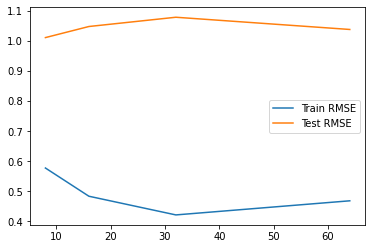

In [37]:
import matplotlib.pyplot as plt

plt.plot(factors, train_rmse_tune, label='Train RMSE')
plt.plot(factors, test_rmse_tune, label='Test RMSE')
plt.legend()
plt.savefig('RMSE model')

# ***More Analysis:***

**Dataset preparation**

In [38]:
!rm -rf lastfm-dataset-1K.tar.gz
!curl -o "lastfm-dataset-1K.tar.gz" "http://www.dcs.gla.ac.uk/~craigm/recsysH/lastfm-dataset-1K.tar.gz"
#backup location
#!curl -o "lastfm-dataset-1K.tar.gz" http://macavaney.us/misc/lastfm-dataset-1K.tar.gz
!tar -zxvf lastfm-dataset-1K.tar.gz
!ls -lh lastfm-dataset-1K/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  641M  100  641M    0     0  98.9M      0  0:00:06  0:00:06 --:--:--  106M
lastfm-dataset-1K/
lastfm-dataset-1K/userid-profile.tsv
lastfm-dataset-1K/README.txt
lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv
total 2.4G
-rw-r--r-- 1 1002 1002 2.2K Mar 23  2010 README.txt
-rw-r--r-- 1 1002 1002  37K Dec 30  2009 userid-profile.tsv
-rw-r--r-- 1 1002 1002 2.4G Mar  4  2010 userid-timestamp-artid-artname-traid-traname.tsv


In [40]:
listens_df = pd.read_csv("lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv",  names=['user', 'timestamp', 'artistid', 'artist', 'trackid', 'trackname'], header=None, sep='\t')

#Some tracks dont seem to have artists or track names, so lets drop them for simplicity.
listens_df = listens_df[listens_df.artist.notnull()]
listens_df = listens_df[listens_df.trackname.notnull()]

#the dataframe is VERY big (19M interactions), so lets just work with a small sample of it (this will mean that effectiveness will be lower, but learning will be MUCH faster).
listens_df = listens_df.sample(n=200000, random_state=np.random.RandomState(20))

In [41]:
listens_df.head()

,user,timestamp,artistid,artist,trackid,trackname
11087179,user_000593,2007-05-14T18:49:03Z,ad996aef-cc1c-42ac-af5c-619c370f4b8a,"Emerson, Lake & Palmer",NaN,Three Fates (Clotho/Lachesis/Atropos)
1911790,user_000093,2008-08-18T22:04:59Z,8c538f11-c141-4588-8ecb-931083524186,Bloc Party,315a301e-e764-4adf-91c6-e90a22320106,Positive Tension
11099786,user_000594,2008-04-06T10:57:45Z,65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab,Metallica,683c89fe-2be8-4ed2-8e58-68b2343cb8d5,Through The Never
12076983,user_000651,2008-05-10T07:14:45Z,3ca09fae-fdee-4771-bab9-244708515a98,Omarion,NaN,Ice Box [Orangefuzzz Weather Advisory Radio Mix]
2680461,user_000137,2009-03-11T23:17:22Z,af84ee9f-534a-4f7f-844b-188ba1c47e87,Los Rodríguez,76b83f07-3763-4c17-8d24-28040d85354a,Dulce Condena


An implicit recommendation approach

In [42]:
from collections import defaultdict
from itertools import count

#we cant trust the musicbrainz ids to exist, so lets build items ids based on artist & trackname attributes
LFMiid_map = defaultdict(count().__next__)
LFMiids = np.array([LFMiid_map[artist+"/"+trackname] for artist,trackname in listens_df[["artist","trackname"]].values ], dtype=np.int32)

LFMuid_map = defaultdict(count().__next__)
LFMuids = np.array([LFMuid_map[uid] for uid in listens_df["user"].values ], dtype=np.int32)
#freeze uid_map and iid_map so no more mapping are created
LFMuid_map.default_factory = None
LFMiid_map.default_factory = None

LFMuid_rev_map = {v: k for k, v in LFMuid_map.items()}
LFMiid_rev_map = {v: k for k, v in LFMiid_map.items()}

from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

#NB: we will set num_users and num_items here - its a good practice.
imp_dataset = Interactions(user_ids=LFMuids, item_ids=LFMiids, num_users=len(LFMuid_map), num_items=len(LFMiid_map))
#we could add the timestamps here if we were doing sequence recommendation

#what have we got.
print(imp_dataset)

<Interactions dataset (973 users x 125076 items x 200000 interactions)>


In [44]:
from spotlight.cross_validation import random_train_test_split

itrain, itest = random_train_test_split(imp_dataset, random_state=np.random.RandomState(20))
print(itrain)
print(itest)

<Interactions dataset (973 users x 125076 items x 160000 interactions)>
<Interactions dataset (973 users x 125076 items x 40000 interactions)>


In [45]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  

imodel = ImplicitFactorizationModel(n_iter=5, 
                                    embedding_dim=32, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(20) # ensure results are repeatable
)
current = time.time()

imodel.fit(itrain, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds" % (diff))

Epoch 0: loss 0.9663112482070922
Epoch 1: loss 0.4953250741481781
Epoch 2: loss 0.19036928775310516
Epoch 3: loss 0.11518941127061844
Epoch 4: loss 0.08347187245488166
Training took 101 seconds


Track Analysis

In [48]:
def tracksForUser(user, k):

  predict_items = imodel.predict(user)
  ranking_items = rankdata(predict_items)
  
  # Sorting and Slicing 

  top_tracks = np.argsort(predict_items)[::-1][0:k]

  track_names = []
  for track in top_tracks:
    track_names.append(LFMiid_rev_map.get(track))

  return track_names

tracksForUser(4, 10)

['Evanescence/Sweet Sacrifice',
 'Mgmt/Kids',
 'The Killers/Bones',
 'Nelly Furtado/Say It Right',
 'Kings Of Leon/Use Somebody',
 'Amy Winehouse/Back To Black',
 'Red Hot Chili Peppers/The Zephyr Song',
 'Radiohead/Fake Plastic Trees',
 'Incubus/Drive',
 'Him/The Funeral Of Hearts']

Aritist Analysis

In [49]:
counting_artist = pd.DataFrame(listens_df[['user','artist']].groupby(['user','artist']).artist.agg('count'))

counting_artist.columns =['Listening_frequency'] # defining column for frequency of listening to an artist

# arrange frequencies in desending order
counting_artist.sort_values(by=['Listening_frequency'], ascending = False).loc[LFMuid_rev_map.get(4),:]

,Listening_frequency
artist,
Soda Stereo,39
Gustavo Cerati,36
Radiohead,31
Lucybell,27
Silvio Rodríguez,16
...,...
Scissor Sisters,1
Sanalejo,1
Saiko,1


In [50]:
from spotlight.evaluation import mrr_score

#evaluate on this dataset takes approx 1 minute
!date
print(mrr_score(imodel, itest).mean())
!date
print(mrr_score(imodel, itest,  train=itrain).mean())
!date

Sat Aug 13 22:10:03 UTC 2022
0.03720125940064275
Sat Aug 13 22:10:33 UTC 2022
0.008104536778740273
Sat Aug 13 22:11:01 UTC 2022
